In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [5]:
!pip install opendatasets --upgrade --quiet
import urllib.request
import opendatasets as od

od.download("https://www.kaggle.com/datasets/georgezwangnottaken/cleaned-data-yoga/data?select=dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: georgezwangnottaken 
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/georgezwangnottaken/cleaned-data-yoga


100%|██████████| 959M/959M [00:11<00:00, 91.1MB/s]


In [6]:
# Define the path to your dataset
data_dir = '/content/cleaned-data-yoga/dataset'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [7]:
# Define the split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

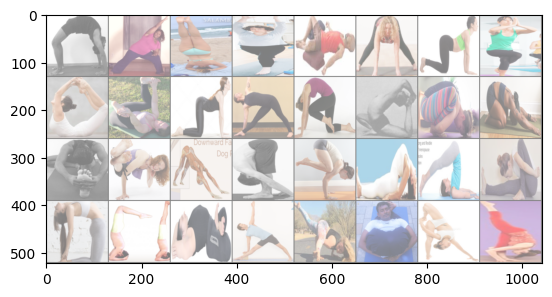

urdhva dhanurasana utthita parsvakonasana salamba sirsasana utthita ashwa sanchalanasana supta baddha konasana prasarita padottanasana bitilasana garudasana dhanurasana ananda balasana bitilasana utthita trikonasana chakravakasana eka pada rajakapotasana ii malasana balasana janu sirsasana parsva bakasana adho mukha svanasana uttanasana bakasana matsyasana halasana marichyasana i ustrasana salamba sirsasana matsyasana parivrtta trikonasana eka pada koundinyanasana ii yoganidrasana urdhva prasarita eka padasana urdhva prasarita eka padasana


In [9]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [11]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [15]:
def get_accuracy(model, dataloader):
  "Gets accuracy for final accuracy and accuracy plots"
  correct=0
  total=0
  with torch.no_grad():
    for imgs, labels in dataloader:

      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          # print("consist")
          imgs = imgs.cuda()
          labels = labels.cuda()

      outputs = model(imgs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      # print(predicted)#weird size mismatch
      # print(labels)

      correct += (predicted == labels).sum().item()#adds sum of them
  return correct/total

### training with plots


In [19]:
import time

def train_plot(model, num_epochs):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  iters,losses,train_acc,valid_acc =[],[],[],[]

  start_time=time.time()
  for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    model.train()  # Set the model to training mode

    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data


      #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          # model.cuda()
          # print("consist")
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            iters.append(epoch * 100 + i)
            losses.append(running_loss / 100)
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, val_loader))

            print(f'Epoch {epoch + 1}, Minibatch {i + 1}, Loss: {running_loss / 100:.3f}')
            print("\tTime Elapsed: % 6.2f s " % (time.time()-start_time))
            running_loss = 0.0

#done training
  print(iters)
  print(losses)

  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()


  plt.title("Accuracy Train Curve")
  plt.plot(iters, valid_acc, label="Validation")
  plt.plot(iters, train_acc, label="Training")
  plt.legend(loc='best')
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.show()
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(valid_acc[-1]))



CUDA is not available.  Training on CPU ...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Minibatch 100, Loss: 4.677
	Time Elapsed:  156.18 s 
Epoch 2, Minibatch 100, Loss: 3.821
	Time Elapsed:  333.79 s 
Epoch 3, Minibatch 100, Loss: 2.871
	Time Elapsed:  510.61 s 
Epoch 4, Minibatch 100, Loss: 1.963
	Time Elapsed:  688.61 s 
Epoch 5, Minibatch 100, Loss: 0.971
	Time Elapsed:  872.35 s 
Epoch 6, Minibatch 100, Loss: 0.315
	Time Elapsed:  1071.72 s 
Epoch 7, Minibatch 100, Loss: 0.116
	Time Elapsed:  1278.06 s 
Epoch 8, Minibatch 100, Loss: 0.051
	Time Elapsed:  1485.30 s 
Epoch 9, Minibatch 100, Loss: 0.034
	Time Elapsed:  1685.04 s 
Epoch 10, Minibatch 100, Loss: 0.036
	Time Elapsed:  1889.91 s 
[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]
[4.676905345916748, 3.8213384699821473, 2.8710484647750856, 1.9627638232707978, 0.9714261907339096, 0.3153581789880991, 0.11644322196021677, 0.05146289880387485, 0.03403294762014411, 0.03609517471399158]


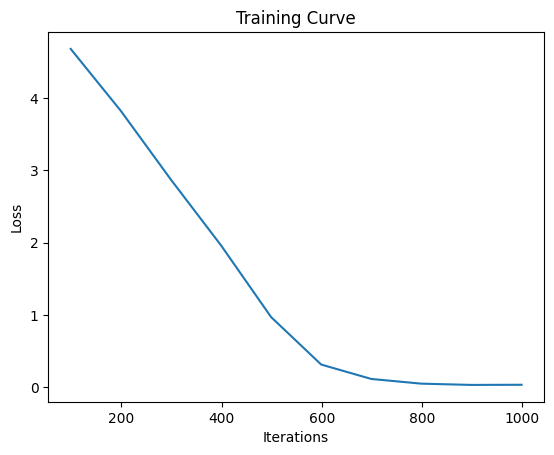

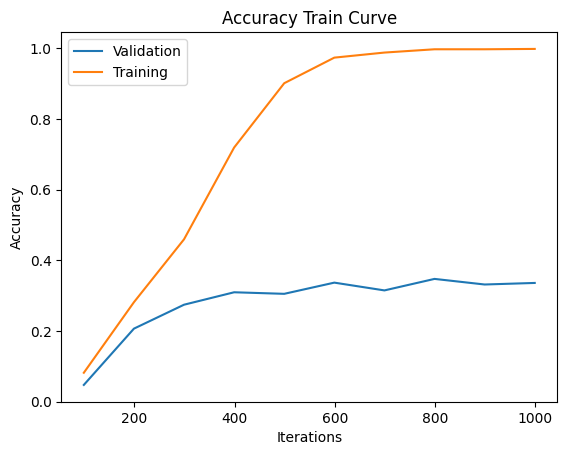

Final Training Accuracy: 0.9979894445840664
Final Validation Accuracy: 0.335971855760774


In [20]:
model = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model, num_epochs=10)

In [23]:
test_acc=get_accuracy(model, test_loader)
print(f'Final Test Accuracy: {100 * test_acc:.2f}%')

Final Test Accuracy: 32.51%
